In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams['lines.linewidth'] = 2
from numpy.linalg import svd
from scipy.optimize import leastsq, least_squares, minimize, differential_evolution
from lmfit import Model
import glob, os
import random, time
from pprint import pprint
from collections import OrderedDict

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the temperature values (replace this with your actual temperature data)
temperatures = np.linspace(400, 200, num=200)  # Example temperature range
#temperatures = np.linspace(470, 200, num=270)  # Example temperature range
# Create a custom colormap for temperature
temp_colors = ['blue', 'yellow', 'red']
n_temp_colors = len(temp_colors)
temp_cmap = LinearSegmentedColormap.from_list('temperature_colormap', temp_colors, N=n_temp_colors * len(temperatures))

# Create a Normalize object for temperature mapping
normalize_temp = Normalize(vmin=min(temperatures), vmax=max(temperatures))

# Define the frequency values (logarithmically spaced)
#frequencies = np.logspace(6, -1, num=71)
frequencies = np.logspace(6, 1, num=51)

# Create a custom colormap for frequency
freq_colors = ['blue', 'yellow', 'red' ]
n_freq_colors = len(freq_colors)
freq_cmap = LinearSegmentedColormap.from_list('frequency_colormap', freq_colors, N=n_freq_colors * len(frequencies))

# Create a Normalize object for frequency mapping
normalize_freq = Normalize(vmin=np.log10(min(frequencies)), vmax=np.log10(max(frequencies)))


def make_square_axes(ax):
    """Make an axes square in screen units.

    Should be called after plotting.
    """
    ax.set_aspect(1 / ax.get_data_ratio())


In [2]:
#data_fit = ["33","38","43","48","53","58","63","68","73","78", "83","88", "93","98", \
#data_fit = ["103","108", "113","118","123","128","133","138","143","148","153","158","163","168","173","178",\
#            "183","188","193","198","203","208","213","218","223","228","233","238","243","248","253","258","263"]
#data_fit = ["43", "63", "83", "103", "123", "143", "163", "183", "203", "223", "243", "263"]

#data_fit = [str(x) for x in np.arange(41,260,1)]
data_fit = [str(x) for x in np.arange(87,260,1)]
#data_fit = ['0'*(3-len(x)) + x for x in data_fit]

print("N data fit: ", len(data_fit))

def read_rawdata(raw_data_path):
    """

    :param raw_data_path: 
    :return:
    """
    list_raw_data = [raw_data_path + x + '.dat' for x in data_fit]
    F_read = []
    Z = []
    ls_00 = []
    ls_temperature = []
    n_cnt = 0
    name_dict = OrderedDict()  # Use OrderedDict to maintain order
    for fd in list_raw_data:
        with open(fd) as fo:
            lines = fo.readlines()
            
            # Get the T value from the second line 
            cur_temp = float(lines[1])-0.3 # -0.3 by taking measurement time ~37 sec on cooling 1C/min
            
            cur_F = []
            cur_Z = []

            for line in lines[7:]:  # Start from the 8th line from 10^6
                if line.strip():
                    xs = [float(vl) for vl in line.split('\t')]
                    cur_F.append(xs[0])
                    cur_Z.append(xs[1] + 1j * xs[2])

            F_read += [cur_F]
            Z += [cur_Z]
            ls_temperature += [cur_temp] * len(cur_F)
            name_dict[fd.split('/')[-1]] = cur_temp

    F_read = np.array(F_read, dtype=np.float64).reshape(1, -1)
    Z = np.array(Z).reshape(1, -1)
    ls_temperature = np.array(ls_temperature, dtype=np.float64)
    
     

    F_fit = F_read.flatten()
    Z_fit = Z.flatten()
    T_fit = ls_temperature.copy()
    pprint(name_dict)
    return F_fit, Z_fit, T_fit, F_read.flatten(), ls_temperature.flatten(), name_dict

#list_raw = sorted(glob.glob(raw_data_path + '*.dat'))
#list_raw = glob.glob(raw_data_path + '*.dat')

#list_raw_data = [x.replace("\\", "/") for x in list_raw if x.endswith(".dat")]

#list_name_data = np.array([x.split('/')[-1] for x in list_raw_data if x.split('/')[-1][:-4] in data_fit])
#list_raw_data = [x for x in list_raw_data if x.split('/')[-1][:-4] in data_fit]

#     kpZ = np.imag(Z) < 0
#     F_fit = F_read[kpZ].flatten()
#     Z_fit = Z[kpZ].flatten()
#     T_fit = ls_temperature[kpZ.flatten()]
    # Use all data (notes 2)

N data fit:  173


#### Fixed and Fit parameters

# Linh utility functions

In [3]:
# Try to reproducible result of differential evolution
#np.random.seed(211)
#random.seed(211)
# Path to raw, output data
raw_data = './data/LLZ_KIMS_rawdata/'
txt_folder = './data/LLZ_fitresults/'
params_folder = './data/LLZ_params/'
os.makedirs(params_folder, exist_ok=True)
os.makedirs(txt_folder, exist_ok=True)



#Fixed parameters
sf = 1.6175
kB=8.617e-5
alpha        = 0.985
alpha_dl = 1
Cstr =5.5e-12
#P_1 = 0.66 # gamma 1
U_1 = 1 # beta 1

#P_2 = 1.8 # gamma 2
#U_2 = 0.5 # beta 2

#fixed_vals = {'shape_factor': sf, 'alpha': alpha, 'DE1_P_1':DE1_P_1, 'DE1_U_1':DE1_U_1,'DE1_P_2':DE1_P_2,\
#              'DE1_U_2':DE1_U_2}
#print('Fixed parameters: ')
#pprint(fixed_vals)
#print()


weighting_name = ['unit', 'dataProportional', 'calcProportional', 'dataModulus', 'calcModulus']
p_name =['P_1','P_2','U_2','L','Rstr','C0','C1','C2','Cdl','CP','tau_1_1','tau_2_1','QWB_1',\
         'R_T_1','R_S_1','ET0','ET1','ET2']

#DE1_U_2      = 4.89572e-01
#alpha        = 0.985

P_1          = 8.33747e-01
P_2          = 1.24324e+00
U_2          = 4.77499e-01
L            = 1e-3 #4.14516e-03
Rstr         = 5.27855e+02
C0           = 3.29066e-12
C1           = 1.27783e-08
C2           = 1.94990e-06
Cdl          = 3.64146e-08
CP           = 4.03204e-06
tau_1_1      = 2.96492e+01
tau_2_1      = 2.42346e+01
QWB_1        = 5.54238e+00
R_T_1        = 1.37492e+01
R_S_1        = 2.27520e+01
ET0          = 5.05098e-01
ET1          = 5.74506e-01
ET2          = 9.17533e-01

guess = np.array([P_1,P_2,U_2,L,Rstr,C0,C1,C2,Cdl,CP,tau_1_1,tau_2_1,QWB_1,R_T_1,R_S_1,ET0,ET1,ET2])

epsilon = np.finfo('float64').eps
epsfcn = np.finfo(np.float32).eps

print("Free parameters: ")
for i in range(len(p_name)):
    print("{:>2} {:>12} = {:>10.5e}".format(i+1, p_name[i], guess[i]))
  
print()

F, Z, Ts, F_orig, Ts_orig, name_dict = read_rawdata(raw_data)

row_header = [''] * (3 * len(p_name))
for idx in range(len(p_name)):
    row_header[3 * idx] = p_name[idx]
    row_header[3 * idx + 1] = p_name[idx] + '_error'
    row_header[3 * idx + 2] = p_name[idx] + '_guess'

guess_arr = np.array(guess)
pv_idx = np.arange(0, 3 * len(guess), 3)
pe_idx = np.arange(1, 3 * len(guess), 3)
guess_idx = np.arange(2, 3 * len(guess), 3)

#leastsq_params = np.zeros((5, len(guess) * 3), dtype=np.float64)
leastsquares_params = np.zeros((5, len(guess) * 3), dtype=np.float64)
minimize_params = np.zeros((5, len(guess) * 3), dtype=np.float64)
differential_evolution_params = np.zeros((5, len(guess) * 3), dtype=np.float64)
ls_temperature = None
list_name_data=None

Free parameters: 
 1          P_1 = 8.33747e-01
 2          P_2 = 1.24324e+00
 3          U_2 = 4.77499e-01
 4            L = 1.00000e-03
 5         Rstr = 5.27855e+02
 6           C0 = 3.29066e-12
 7           C1 = 1.27783e-08
 8           C2 = 1.94990e-06
 9          Cdl = 3.64146e-08
10           CP = 4.03204e-06
11      tau_1_1 = 2.96492e+01
12      tau_2_1 = 2.42346e+01
13        QWB_1 = 5.54238e+00
14        R_T_1 = 1.37492e+01
15        R_S_1 = 2.27520e+01
16          ET0 = 5.05098e-01
17          ET1 = 5.74506e-01
18          ET2 = 9.17533e-01

OrderedDict([('87.dat', 416.67),
             ('88.dat', 415.39),
             ('89.dat', 414.12),
             ('90.dat', 412.84999999999997),
             ('91.dat', 411.57),
             ('92.dat', 410.31),
             ('93.dat', 409.03999999999996),
             ('94.dat', 407.77),
             ('95.dat', 406.52),
             ('96.dat', 405.26),
             ('97.dat', 404.0),
             ('98.dat', 402.75),
             ('99.dat'

In [10]:
def Linh_func(params, F, T, simulation=False, type=None, wgt=None):
    """
    params: [C1, tau_1_1, tau_2_1, tau_3_1, AT, ET, Rs_1, Qw_1, Qw_2]
    params: [8.550E-12, 39.42, 36.85, 32.00, 12.71, 0.5434, 18.82, 5.810, 0.4687]
    simualation: simualation or not, default, not simulation
    """
    P_1,P_2,U_2,L,Rstr,C0,C1,C2,Cdl,CP,tau_1_1,tau_2_1,QWB_1,R_T_1,R_S_1,ET0,ET1,ET2 = params
    
    
    iomega = 1j * 2 * np.pi * F

    # Z_inductance (note 1)
    Rser=0   #40
    Z_str = Rser+ 1/(1/(iomega*L)+1/Rstr)
    #Z_str = Rser+ iomega*L
        
    #DE1_P_3 = 1 / DE1_U_3
    
    tau_1_2 = ET0
    tau_2_2 = ET1
    R_T_2 = ET1
    R_S_2 = ET2
    #R_P_2 = ET0
    QWB_2 = ET2/2
    #R_short_2 =ET2    
    # Individual variable
            
    #kB = 0.00008617

    R_T = np.divide(T, np.exp(-R_T_2/ (kB * T) + R_T_1))
    R_S = np.divide(T, np.exp(-R_S_2/ (kB * T) + R_S_1))
    #R_P = np.divide(T, np.exp(-R_P_2/ (kB * T) + R_P_1))
    #R_short = np.divide(T, np.exp(-R_short_2/ (kB * T) + np.log(R_short_1)))
    #sigma = 1/(sf * R_T)    

    # NCL part
    alpha        = 9.84997e-01
    #C0=4.28E-12  #4.28e-12/1.6175/8.854e-14
    Z_00 = 1 / np.multiply(np.power(iomega, alpha), C0)
    
    C00 = Cstr + 1 / np.multiply(iomega, Z_00) #stray capacitance
    #C00 = np.divide(C0, np.power(1 + np.power(np.multiply(iomega, tau_0), alpha),1))
    # DE1
    CHN1 = C1 / T
    THN1= np.divide(1, np.exp(-tau_1_2/ (kB * T) + tau_1_1))
    DHN1 = np.divide(CHN1, np.power(1 + np.power(np.multiply(iomega, THN1), U_1), P_1))
    #ZHN1 = 1 / np.multiply(iomega, DHN1)

    # DE2
    CHN2 = C2 / T
    THN2= np.divide(1, np.exp(-tau_2_2/ (kB * T) + tau_2_1))
    DHN2 = np.divide(CHN2, np.power(1 + np.power(np.multiply(iomega, THN2), U_2), P_2))
    ZHN2 = 1 / (np.multiply(iomega, DHN2))

    
    ## Bisquert
    C_P = CP/T
        
    Z_S = R_S
    Y_P = np.multiply(iomega, C_P)
    
    # Z_B
    #DE1_P_B = 1
    #DE1_U_B = 0.5              
    #CHN_B = CB/T
    #THN_B = np.divide(1, np.exp(-tau_B_2/ (kB * T) + tau_B_1))
    #DHN_B = np.divide(CHN_B, np.power(1 + np.power(np.multiply(iomega, THN_B), DE1_U_B), DE1_P_B))
    #ZHN_B = 1 / np.multiply(iomega, DHN_B)                  
    #Z_B = ZHN_B   
    
    #ZB
    QWB = np.divide(np.exp(-QWB_2/ (kB * T)+ QWB_1),T) ##T
    ZWB = 1 / np.multiply(np.power(iomega, 0.5), QWB)
    Z_B=ZWB
    CWB = 1 / np.multiply(iomega, ZWB)
    #Z_B=1e-20
    ## Bisquert
    
    ZS_d_YP = np.divide(Z_S, Y_P)
    Z0=np.sqrt(ZS_d_YP) # Characteristic Impedance
    
    ZS_m_YP = np.multiply(Z_S, Y_P)

    k = np.sqrt(ZS_m_YP)
    inf_index = k >= 710 #600
    tnh = np.zeros(k.shape, dtype=complex)
    tnh[inf_index] = 1 
    tnh[~inf_index] = np.tanh(k[~inf_index])

    Zbis_up= Z_B + np.multiply(Z0,tnh)
    Zbis_down = Z0 + np.multiply(Z_B,tnh) 
    Z_Bis = np.multiply(Z0, np.divide(Zbis_up, Zbis_down))
    Y_Bis = 1/Z_Bis

    ## Bulk capcitance;
    #CDH = C00 + DHN1 + DHN2 
    CDH = C00 + DHN1 + DHN2 
    YCDH = np.multiply(iomega, CDH)
    #Y2 = 1 / ZBis
                    
    # low frequency response;
    Cdl=Cdl/(T**(0.5))
    #Cdl=Cdl/T
    Y1= np.multiply(np.power(iomega, alpha_dl), Cdl) + Y_Bis                    
    #Y1=np.multiply(iomega, DHN3)
    #Y2=np.multiply(np.power(iomega, 0.5), Qw1)
    Z2=R_T + 1/Y1
    Y2=1/Z2
    Y3 = YCDH+Y2 #+ 1/R_short
    Z3 = 1/Y3
    #Z3 = 1/YCDH   
     
    # Note, add L_inductance
    #Zt = 1/YCDH  
    Zt = Z3 + Z_str
    Yt = 1 / Zt
    sigma = np.real(Yt) / sf

    # Output:
    # Impedance
    zz1 = np.real(Zt)
    zz2 = np.imag(-Zt)

    # Admittance
    Ytp = np.real(1 / Zt)
    Yt1 = np.transpose(Ytp)

    # Capacitance
    Ctp = np.real(1 / np.multiply(iomega, Zt))
    Ct1 = np.transpose(Ctp)
    #Ctp = np.real(1 / np.multiply(iomega, Zt))
    #Ct1 = np.real(C00+CHN1+CHN2+Cdl+C_P+CWB)
    
    # Capacitance
    Ctq = np.imag(1 / np.multiply(iomega, Zt))
    Ct2 = np.transpose(Ctq)

    # Conductivity
    TD = np.log(np.multiply(sigma, T))
    x = 1000 / T 

    if simulation:
        Linh_simulation(F, T, TD, Ct1, Ct2, Yt1, Zt, type, wgt)
    return Zt


def cost_vector(par, Z, F, T, weighting):
    """
    Type of weighting
    2: data-proportional
    3: calc-proportional
    4: data-modulus
    5: calc-modulus
    otherwise: unit weighting
    """
    Zt = np.reshape(Z, (1, -1))
    for i in range(par.size):
        if par[i] <= 0:
            return 1.0e16 * np.ones(Zt.size * 2)

#     calc = np.reshape(Linh_func_LLZ(par * guess, F, T), (1, -1)) # Original
    calc = np.reshape(Linh_func(par, F, T), (1, -1))    # Linh

    if weighting == 2:
        # data-proportional
        error = Zt - calc
        error.real = error.real / Zt.real
        error.imag = error.imag / Zt.imag
    elif weighting == 3:
        # calc-proportional
        error = Zt - calc
        error.real = error.real / calc.real
        error.imag = error.imag / calc.imag
    elif weighting == 4:
        # data-modulus
        error = (Zt - calc) / np.abs(Zt)
    elif weighting == 5:
        # calc-modulus
        error = (Zt - calc) / np.abs(calc)
    else:
        # Unit weighting (no weighting, weighting=1)
        error = Zt - calc

    e1d = np.zeros(Zt.size * 2, dtype=np.float64)
    e1d[0:e1d.size:2] = error.real
    e1d[1:e1d.size:2] = error.imag
    return e1d


def cost_scalar(par, Z, F, T, weighting):
    """
    Type of weighting
    1: unit weighting
    2: data-proportional
    3: calc-proportional
    4: data-modulus
    5: calc-modulus
    """
    e1d = cost_vector(par, Z, F, T, weighting)
    return np.sum(np.array(e1d) ** 2)


def write_results(Z_model, ls_temperature, list_name_data, txt_name):
    """
    Write results of current model to files
    :return:
    """
    for indx in range(Z_model.shape[0]):
        F_indx = F[indx]
        T = ls_temperature[indx]
        txt_write = np.transpose(np.vstack((F_indx, np.real(Z_model[indx, :]), np.imag(Z_model[indx, :]))))
        pd.DataFrame(txt_write, columns=['Frequency', 'Real Impedance', 'Imaginary Impedance']).to_csv(
            txt_name + list_name_data[indx], encoding='ascii', sep='\t', header=True, index=False)
        with open(txt_name + list_name_data[indx], 'r+') as fd:
            contents = fd.read()
            fd.seek(0, 0)
            fd.write('\n{}\n\n\n\n'.format(T) + contents)
            
            
def Linh_simulation(F, T, TD, Ct1,Ct2, Yt1, Zt, type=None, wgt=None):
    zz1 = np.real(Zt)
    zz2 = np.imag(-Zt)
    x = 1000 / T
    run_simu = False
    os.makedirs(txt_folder + type + "/" + weighting_name[wgt-1], exist_ok=True)
    
    Yt_raw = np.transpose(np.real(np.divide(1.0, Z)))
    sigma_raw = Yt_raw/sf
    Ct_raw = np.real(1 / np.multiply(1j * 2 * np.pi * F, Z))
    Ct1_raw = np.transpose(Ct_raw)
    Ct2_raw = np.divide(Yt_raw, 2 * np.pi * F)
    
     # Conductivity
    TD_raw = np.log(np.multiply(sigma_raw, T))
    
    
    # Create a ScalarMappable for temperature mapping
    temp_sm = ScalarMappable(cmap=temp_cmap, norm=normalize_temp)
    temp_sm.set_array([])  # An empty array for now

    # Create a ScalarMappable for frequency mapping
    freq_sm = ScalarMappable(cmap=freq_cmap, norm=normalize_freq)
    freq_sm.set_array([])  # An empty array for now
    
    
    # Create a 3x2 grid layout
    fig1 = plt.figure(figsize=(13, 13))
    gs1 = gridspec.GridSpec(3, 2)

    # Create subplots
    ax1 = plt.subplot(gs1[0, 0])
    ax2 = plt.subplot(gs1[0, 1])
    ax3 = plt.subplot(gs1[1, 0])
    ax4 = plt.subplot(gs1[1, 1])
    ax5 = plt.subplot(gs1[2, 0])
    ax6 = plt.subplot(gs1[2, 1])
 
    # Center the subplots within the figure
    plt.subplots_adjust(left=0.25, right=0.85, top=0.8, bottom=0.1, wspace=0.2, hspace=0.3)                   

    
    F_uq = np.unique(F)
    # Select every other frequency from the F array
    F_uq = F_uq[::2]
    
    for fq in F_uq:
        freq_color = freq_cmap(normalize_freq(np.log10(fq)))  # Map frequencies to a color              

        fq_index = (F == fq)
        ax1.plot(x[fq_index], TD[fq_index]/2.303, color=freq_color,linewidth=0.5)
        ax1.plot(x[fq_index], TD_raw[fq_index]/2.303, 'o', markersize=0.5, color=freq_color)
        ax1.set_prop_cycle(None)
        # Set explicit x-axis limits for both main and top axes
        x1_limit_main = [2.4, 5.2]
        ax1.set_xlim(2.0,5.2)
        ax1.set_ylim([-7.5,-0.5])
        ax1.tick_params(axis='both', direction='in', which='both')
        ax1.set_xticks([2.0,2.5,3.0,3.5,4.0,4.5,5.0])  # Major ticks 
        ax1.set_xticks(np.arange(2.0, 5.2, 0.1), minor=True)  # Minor ticks in between major ticks
        ax1.set_yticks(np.arange(-7, 0, 1))  # Major ticks 
        ax1.set_xlabel('1000/T K$^{-1}$')
        ax1.set_ylabel('Log($\sigma$T /$\Omega^{-1}$ cm$^{-1}$ K)')
        make_square_axes(ax1)        
     
        ax2.plot(x[fq_index], TD[fq_index]/2.303, color=freq_color,linewidth=0.5)
        ax2.plot(x[fq_index], TD_raw[fq_index]/2.303, 'o', markersize=0.5, color=freq_color)
        ax2.set_prop_cycle(None)
        ax2.set_xlim([2.2, 3.5])
        ax2.set_ylim([-4.5,-0.5])
        ax2.tick_params(axis='both', direction='in', which='both')
        ax2.set_xticks(np.arange(2.2, 3.5, 0.2))  # Major ticks 
        ax2.set_xticks(np.arange(2.2, 3.5, 0.2), minor=True)  # Minor ticks in between major ticks
        ax2.set_yticks(np.arange(-4.0, 0, 1))  # Major ticks 
        ax2.set_yticks(np.arange(-4.5, -0.5, 1), minor=True)  # Minor ticks in between major ticks
        ax2.set_xlabel('1000/T K$^{-1}$')
        ax2.set_ylabel('Log($\sigma$T /$\Omega^{-1}$ cm$^{-1}$ K)')
        make_square_axes(ax2)              

    
    # Convert the x-axis values to Celsius temperature
    x1_ticks_celsius = np.array([200,100, 50, 0,-30, -50, -70])
    x1_ticks_kelvin = 1000 / (x1_ticks_celsius + 273.15)
    
    
    # Create top axes for Celsius temperature without sharing y-axis
    ax1_top = ax1.secondary_xaxis('top')
    ax1_top.set_xlim(ax1.get_xlim())
    ax1_top.set_xticks(x1_ticks_kelvin)
    ax1_top.set_xticklabels(x1_ticks_celsius)
    ax1_top.set_xlabel('T/$^\circ$C')
    ax1_top.tick_params(axis='x', direction='in', which='both', top=True, bottom=False, labelbottom=False, labeltop=True, width=0.5)

    # Convert the x-axis values to Celsius temperature
    x2_ticks_celsius = np.array([150,100,70,50,30])
    x2_ticks_kelvin = 1000 / (x2_ticks_celsius + 273.15)
    
    # Create top axes for Celsius temperature without sharing y-axis
    ax2_top = ax2.secondary_xaxis('top')
    ax2_top.set_xlim(ax2.get_xlim())
    ax2_top.set_xticks(x2_ticks_kelvin)
    ax2_top.set_xticklabels(x2_ticks_celsius)
    ax2_top.set_xlabel('T/$^\circ$C')
    ax2_top.tick_params(axis='x', direction='in', which='both', top=True, bottom=False, labelbottom=False, labeltop=True, width=0.5)
           
    
    T_uq = np.unique(T)
    # Select every other frequency from the F array
    T_uq = T_uq[::5]
    
    
    for temp in T_uq:
        
        temp_color = temp_cmap(normalize_temp(temp))  # Map temperature to a color
        
        # if (len(T_uq) <= 100) or (len(T_uq) > 100 and temp in temp_draw):
        temp_idx = (T == temp)

               
        
        ax3.plot(np.log10(F[temp_idx]), np.log10(np.abs(Ct1[temp_idx])), color=temp_color,linewidth=0.5)
        ax3.plot(np.log10(F[temp_idx]), np.log10(np.abs(Ct1_raw[temp_idx])), 'o', markersize=0.5, color=temp_color)
        ax3.set_prop_cycle(None)
        ax3.set_xlabel('Log(Frequency/Hz)')
        ax3.set_ylabel('Log(C$^\prime$/F)')
        ax3.set_xlim([1,6.5])
        ax3.set_ylim([-11.5,-7])              
        ax3.tick_params(axis='both', direction='in', which='both')
        ax3.set_xticks(np.arange(1, 7, 1))  # Major ticks at 0, 2, 4, 6, 8
        ax3.set_xticks(np.arange(1.5, 6.5, 1), minor=True)  # Minor ticks in between major ticks
        ax3.set_yticks(np.arange(-11, -6, 1))  # Major ticks 
        #ax2.set_title('Capacitance')
        make_square_axes(ax3)                     
                
        ax4.plot(np.log10(F[temp_idx]), np.log10(np.abs(Yt1[temp_idx])), color=temp_color,linewidth=0.25)
        ax4.plot(np.log10(F[temp_idx]), np.log10(np.abs(Yt_raw[temp_idx])), 'o', markersize=0.5, color=temp_color)
        ax4.set_prop_cycle(None)
        ax4.set_xlabel('Log(Frequency/Hz)')
        ax4.set_ylabel('Log(Y$^\prime$/$\Omega^{-1}$)')
        ax4.set_xlim([1,6.5])
        ax4.set_ylim([-10,-3])
        ax4.tick_params(axis='both', direction='in', which='both')
        ax4.set_xticks(np.arange(1, 7, 1))  # Major ticks at 0, 2, 4, 6, 8
        ax4.set_xticks(np.arange(1.5, 6.5, 1), minor=True)  # Minor ticks in between major ticks
        ax4.set_yticks(np.arange(-10, -2, 1))  # Major ticks 
        make_square_axes(ax4)       
               
        ax5.plot(np.log10(np.abs(np.real(Zt[temp_idx]))), np.log10(np.abs(np.imag(Zt[temp_idx]))),color=temp_color,linewidth=0.5)
        ax5.plot(np.log10(np.abs(np.real(Z[temp_idx]))), np.log10(np.abs(np.imag(Z[temp_idx]))), 'o', markersize=0.5,color=temp_color)
        ax5.set_prop_cycle(None)           
        ax5.set_xlabel('Log(|Z$^\prime$/$\Omega$|)')
        ax5.set_ylabel('Log(|Z$^{\prime\prime}$/$\Omega$|)')
        ax5.set_xlim([2.5, 8.5])
        ax5.set_ylim([2.5,9])
        ax5.tick_params(axis='both', direction='in', which='both')
        ax5.set_xticks(np.arange(3,9,1))  # Major ticks 
        ax5.set_yticks(np.arange(3,10,1))         
        make_square_axes(ax5)
    
        ax6.plot(np.log10(np.abs(Ct1[temp_idx])), np.log10(np.abs(Ct2[temp_idx])),color=temp_color,linewidth=0.5)
        ax6.plot(np.log10(np.abs(Ct1_raw[temp_idx])), np.log10(np.abs(Ct2_raw[temp_idx])), 'o', markersize=0.5,color=temp_color)
        ax6.set_prop_cycle(None)
        ax6.set_xlabel('Log(|C$^\prime$/F|)')
        ax6.set_ylabel('Log(|C$^{\prime\prime}$/F|)')
        ax6.set_xlim([-11.5, -7])
        ax6.set_ylim([-14,-7])
        ax6.tick_params(axis='both', direction='in', which='both')
        ax6.set_xticks(np.arange(-11, -6, 1))  # Major ticks 
        ax6.set_yticks(np.arange(-14, -6, 1)) 
        make_square_axes(ax6)         
    
        
        
        for nm, key in name_dict.items():
            if key == temp:
                txt_name = txt_folder + type + "/" + weighting_name[wgt-1] + "/" + nm
                break
        
        write_data = np.vstack((F[temp_idx], np.real(Zt[temp_idx]), np.imag(Zt[temp_idx]))).T
        pd.DataFrame(write_data, columns=['Frequency', 'Real Impedance', 'Imaginary Impedance']).to_csv(
            txt_name, encoding='ascii', sep='\t', header=True, index=False)
        with open(txt_name, 'r+') as fd:
            contents = fd.read()
            fd.seek(0, 0)
            fd.write('\n{}\n\n\n\n'.format(temp) + contents)  
    
    
    # For temperature color scale on each subplot
    cbar_temp_ax3 = plt.colorbar(temp_sm, ax=ax3, label='T/K', shrink=0.5, anchor=(0.0, 0.95))
    cbar_temp_ax4 = plt.colorbar(temp_sm, ax=ax4, label='T/K', shrink=0.5, anchor=(0.0, 0.95))
    cbar_temp_ax5 = plt.colorbar(temp_sm, ax=ax5, label='T/K', shrink=0.5, anchor=(0.0, 0.95))
    cbar_temp_ax6 = plt.colorbar(temp_sm, ax=ax6, label='T/K', shrink=0.5, anchor=(0.0, 0.95))

    # For frequency color scale on each subplot
    cbar_freq_ax1 = plt.colorbar(freq_sm, ax=ax1, label='Log(Freq/Hz)', shrink=0.5, anchor=(0.0, 0.95))
    cbar_freq_ax2 = plt.colorbar(freq_sm, ax=ax2, label='Log(Freq/Hz)', shrink=0.5, anchor=(0.0, 0.95))
    
   # Add labels (a), (b), (c), (d), (e), (f) under the subplots
    ax1.text(0.5, -0.22, "(a)", ha="center", va="center", transform=ax1.transAxes, fontsize=12)
    ax2.text(0.5, -0.22, "(b)", ha="center", va="center", transform=ax2.transAxes, fontsize=12)
    ax3.text(0.5, -0.22, "(c)", ha="center", va="center", transform=ax3.transAxes, fontsize=12)
    ax4.text(0.5, -0.22, "(d)", ha="center", va="center", transform=ax4.transAxes, fontsize=12)
    ax5.text(0.5, -0.22, "(e)", ha="center", va="center", transform=ax5.transAxes, fontsize=12)
    ax6.text(0.5, -0.22, "(f)", ha="center", va="center", transform=ax6.transAxes, fontsize=12)   
  
    # Conductivity guide line
    
  
     
   
    
    # Save and show the overview plots
    plt.savefig('overview.png', dpi=600)
    plt.show()
    plt.close(fig1)
    
    
    T_uq_imp = T_uq[::3]
    # Fix the number of subplots in each row
    num_cols = 4

    # Calculate the number of rows based on the total number of plots
    num_rows = -(-len(T_uq_imp) // num_cols)  # Equivalent to math.ceil(len(T_uq_imp) / num_cols)
    
    # Create grid layout
    fig2 = plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    gs2 = gridspec.GridSpec(num_rows, num_cols, wspace=0.4, hspace=0.4)
    
     # Create individual subplots for each temperature
    for i, temp in enumerate(T_uq_imp):
        #print(f"Processing temperature: {temp}")
        temp_color = temp_cmap(normalize_temp(temp))  # Map temperature to a color
        temp_idx = (T == temp)
        temp_C = round(temp - 273.15,2)    
        # Calculate subplot position
        row = i // num_cols
        col = i % num_cols

        # Create a new subplot for each temperature
        ax = plt.subplot(gs2[row, col])

        # Adjust the thickness of all axes spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        # Plot the data for the current temperature with specified color
        # Plot the data for the current temperature with specified color
        ax.plot(np.real(Zt[temp_idx]), -np.imag(Zt[temp_idx]), linewidth=2)
        ax.plot(np.real(Z[temp_idx]), -np.imag(Z[temp_idx]), 'o', markersize=3)

        # Set the color of the lines and markers
        for line in ax.lines:
            line.set_color(temp_color)
        for marker in ax.collections:
            marker.set_color(temp_color)

        # Set the tick label format and font size
        #formatter = ticker.ScalarFormatter(useMathText=True)
        #formatter.set_powerlimits((-2, 3))  # Adjust the limits to control when to use scientific notation
   
        ax.set_xlabel('Z$^\prime$/$\Omega$',fontsize=20)
        ax.set_ylabel('-Z$^{\prime\prime}$/$\Omega$',fontsize=20)
        ax.tick_params(axis='both', direction='in', which='both',width=1, labelsize=20)
        #Set the tick label format
        ax.ticklabel_format(axis='both', style='scientific', scilimits=(-2, 3))
        ax.xaxis.get_offset_text().set_fontsize(20)  # Increase the font size of the exponent for the y-axis
        ax.yaxis.get_offset_text().set_fontsize(20)  # Increase the font size of the exponent for the y-axis
        ax.axis('equal')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
        ax.autoscale_view()
        ax.set_title(f"T = {temp_C}$^\circ$C",fontsize=20)
        # Set the tick label format and font size
        #formatter = ticker.StrMethodFormatter("{x:.1e}")
        #ax.xaxis.set_major_formatter(formatter)
        #ax.yaxis.set_major_formatter(formatter)
    # Assuming you have a function make_square_axes
    # Adjust layout to prevent clipping of labels
    #plt.tight_layout()

    # Save and show the entire set of plots
    plt.savefig('impedance_plots.png', dpi=150)
    plt.show()
    plt.close(fig2)
    
    # Create grid layout
    fig3 = plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    gs3 = gridspec.GridSpec(num_rows, num_cols, wspace=0.4, hspace=0.4)
        # Create individual subplots for each temperature
    for i, temp in enumerate(T_uq_imp):
        #print(f"Processing temperature: {temp}")
        temp_color = temp_cmap(normalize_temp(temp))  # Map temperature to a color
        temp_idx = (T == temp)
        temp_C = round(temp - 273.15,2)    
        # Calculate subplot position
        row = i // num_cols
        col = i % num_cols

        # Create a new subplot for each temperature
        ax = plt.subplot(gs3[row, col])

        # Adjust the thickness of all axes spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        # Plot the data for the current temperature with specified color
        ax.plot(Ct1[temp_idx], -Ct2[temp_idx], linewidth=2)
        ax.plot(Ct1_raw[temp_idx], Ct2_raw[temp_idx], 'o', markersize=3)

        # Set the color of the lines and markers
        for line in ax.lines:
            line.set_color(temp_color)
        for marker in ax.collections:
            marker.set_color(temp_color)

        # Set the tick label format and font size
        #formatter = ticker.ScalarFormatter(useMathText=True)
        #formatter.set_powerlimits((-2, 3))  # Adjust the limits to control when to use scientific notation

        
        ax.set_xlabel('C$^\prime$/F',fontsize=20)
        ax.set_ylabel('C$^{\prime\prime}$/F',fontsize=20)     
        ax.tick_params(axis='both', direction='in', which='both',width=1, labelsize=20)
        #Set the tick label format
        ax.ticklabel_format(axis='both', style='scientific', scilimits=(-2, 3))
        ax.xaxis.get_offset_text().set_fontsize(20)  # Increase the font size of the exponent for the y-axis
        ax.yaxis.get_offset_text().set_fontsize(20)  # Increase the font size of the exponent for the y-axis
        ax.axis('equal')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
        ax.autoscale_view()
        ax.set_title(f"T = {temp_C}$^\circ$C",fontsize=20)
        # Set the tick label format and font size
        #formatter = ticker.StrMethodFormatter("{x:.1e}")
        #ax.xaxis.set_major_formatter(formatter)
        #ax.yaxis.set_major_formatter(formatter)
    # Assuming you have a function make_square_axes
    # Adjust layout to prevent clipping of labels
    #plt.tight_layout()

    # Save and show the entire set of plots
    plt.savefig('capacitance_plots.png', dpi=150)
    plt.show()
    plt.close(fig3)
               

In [4]:
# Conductivity guide line
    #kB = 8.617e-5
    P_1 = guess[0]
    P_2 = guess[1]
    U_2 = guess[2]
    L = guess[3]
    Rstr = guess[4]
    C0 = guess[5]
    C1 = guess[6]
    C2 = guess[7]
    Cdl = guess[8]
    CP = guess[9]
    tau_1_1 = guess[10]
    tau_2_1 = guess[11]
    QWB_1 = guess[12]
    R_T_1 = guess[13]
    R_S_1=guess[14]
    ET0 = guess[15]
    ET1 = guess[16]
    ET2 = guess[17]
    R_T_1=guess[13]
    R_S_1=guess[14]
    R_T_2=ET1
    R_S_2=ET2
    tau_1_2=ET0
    x = np.linspace(2.0, 5, 100)  # Replace with your actual data
    T=1000/x
    R_T = np.divide(T, np.exp(-R_T_2/ (kB * T) + R_T_1))
    R_S = np.divide(T, np.exp(-R_S_2/ (kB * T) + R_S_1))
    
    # DE1
    CHN1 = C1 / T
    THN1= np.divide(1, np.exp(-tau_1_2/ (kB * T) + tau_1_1))
    iomega= 1j /THN1*1e-5
    DHN1 = np.divide(CHN1, np.power(1 + np.power(np.multiply(iomega, THN1), U_1), P_1))
    HN1=Cstr+C0+DHN1
    ZHN1 = 1 / np.multiply(iomega, HN1)
    #YHN1 = 1/ZHN1
    R_H=np.real(ZHN1)
        
    R_tot=R_T+R_S/3
    
    # Calculate y values for each plot
    y1 = np.log10(T / R_H) - np.log10(sf)
    y2 = np.log10(T / R_T) - np.log10(sf)
    y3 = np.log10(T / R_tot) - np.log10(sf)
    
    # Create a DataFrame to hold the data
    data = {
    'x': x,
    'T/R_H': y1,
    'T/R_T': y2,
    'T/R_tot': y3
    }
    df = pd.DataFrame(data)

    # Adjust pandas settings to print all rows
    pd.set_option('display.max_rows', None)
    # Print the DataFrame
    print(df)
    
        
    ax1.plot(x,y1,color='tab:gray',linewidth=1,linestyle='--')
    ax1.plot(x,y2,color='k',linewidth=1,linestyle='--')
    ax1.plot(x,y3,color='k',linewidth=1,linestyle='--')
   
    ax2.plot(x,y1,color='tab:gray',linewidth=1,linestyle='--')
    ax2.plot(x,y2,color='k',linewidth=1,linestyle='--')
    ax2.plot(x,y3,color='k',linewidth=1,linestyle='--')
    
  
    

IndentationError: unexpected indent (3306034942.py, line 3)

#### Simulation using initial values

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31116\3676626264.py:88: RuntimeWarning: overflow encountered in tanh
  tnh[~inf_index] = np.tanh(k[~inf_index])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31116\3676626264.py:234: RuntimeWarning: invalid value encountered in log
  TD_raw = np.log(np.multiply(sigma_raw, T))


           x     T/R_H     T/R_T    T/R_tot
0   2.000000  0.018496 -0.028632  -0.076950
1   2.030303 -0.061970 -0.116374  -0.170516
2   2.060606 -0.142351 -0.204117  -0.264735
3   2.090909 -0.222649 -0.291859  -0.359672
4   2.121212 -0.302868 -0.379601  -0.455390
5   2.151515 -0.383011 -0.467343  -0.551958
6   2.181818 -0.463081 -0.555086  -0.649447
7   2.212121 -0.543080 -0.642828  -0.747929
8   2.242424 -0.623010 -0.730570  -0.847477
9   2.272727 -0.702875 -0.818313  -0.948165
10  2.303030 -0.782677 -0.906055  -1.050064
11  2.333333 -0.862417 -0.993797  -1.153243
12  2.363636 -0.942098 -1.081539  -1.257767
13  2.393939 -1.021722 -1.169282  -1.363694
14  2.424242 -1.101291 -1.257024  -1.471079
15  2.454545 -1.180806 -1.344766  -1.579965
16  2.484848 -1.260270 -1.432508  -1.690388
17  2.515152 -1.339684 -1.520251  -1.802373
18  2.545455 -1.419049 -1.607993  -1.915934
19  2.575758 -1.498368 -1.695735  -2.031073
20  2.606061 -1.577641 -1.783477  -2.147782
21  2.636364 -1.656871 -1.871220

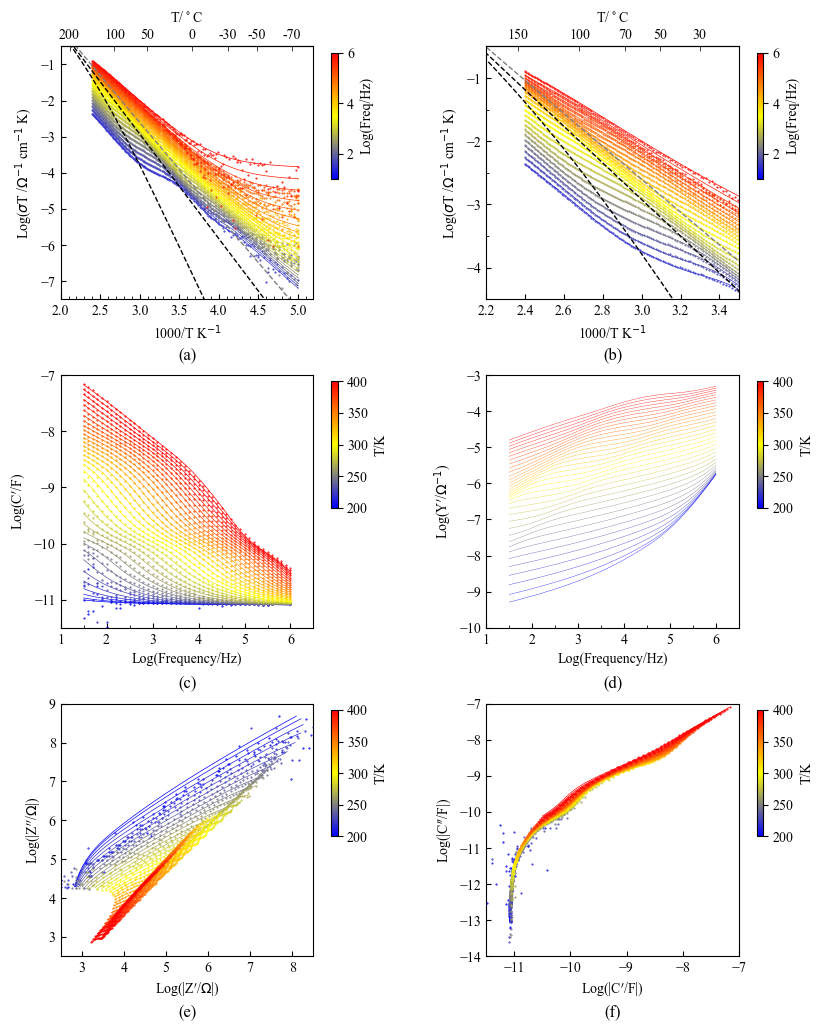

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7958 but corresponding boolean dimension is 100

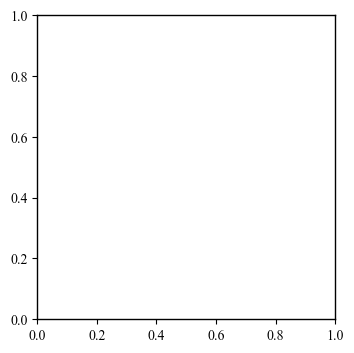

In [7]:
txt_name = txt_folder + "simulation/"
Z_model_simulation = Linh_func(guess, F_orig, Ts_orig, True, 'Simulation', 1)



#### Scipy leastsquare fitting

In [8]:
def Linh_least_squares(guess, Z, F, T, weighting_type, ls_temperature, list_name_data, txt_folder):
    if weighting_type not in [2, 3, 4, 5]:
        weighting_type = 1
    start = time.time()
    
    lower_bnds = [1e-20] * guess.size
    upper_bnds = [np.inf] * guess.size
    #upper_bnds[0] = 1
    upper_bnds[0] = 1.0  # boundary for alpha
    upper_bnds[1] = 1.5  # boundary for alpha
    upper_bnds[2] = 0.5 
    r_lsq = least_squares(cost_vector, guess, args=(Z, F, T, weighting_type), bounds=(lower_bnds, upper_bnds), 
                          max_nfev=1000000, ftol=epsilon, gtol=epsilon, xtol=epsilon, verbose=1)

    # Calculate the Jacobian matrix condition number
    jac_condition_number = np.linalg.cond(r_lsq.jac)
    print("Condition Number of Jacobian:", jac_condition_number)
   
    # Perform Singular Value Decomposition
    _, s, vh = svd(r_lsq.jac, full_matrices=False)
    threshold = epsilon * np.max(r_lsq.jac.shape) * s[0]
    s = s[s > threshold]
    vh = vh[:s.size]
    p_cov = np.dot(vh.T / s ** 2, vh)
    p_cov = p_cov * cost_scalar(r_lsq.x, Z, F, T, weighting_type) / (Z.size - guess.size)
    
    # Original code (multiply guess)
#     pe = np.sqrt(np.diag(p_cov))*guess
#     r_lsq.x = r_lsq.x*guess
    pe = np.sqrt(np.diag(p_cov))
    
    print("\n Least_squares " + weighting_name[weighting_type - 1] + "\n")
    print("                Fit          Errors       Initial" +"\n")
    for i in range(guess.size):
        print("{:>12} : ".format(p_name[i]), "{:10.5e}  {:10.5e}  {:10.5e}".format(r_lsq.x[i], pe[i], guess[i]))

    print("\nResidual = {:10.8e}".format(np.sum(abs(Z - Linh_func(r_lsq.x, F, T)))))
    print("The number of function calls: ", r_lsq.nfev)
    print("Success: ", r_lsq.success)
    print(r_lsq.status, r_lsq.message)
    
    tt=time.gmtime(time.time()-start)
    print("Elapsed time :  {:2} hour. {:2} min. {:2} sec.".format(tt.tm_hour, tt.tm_min, tt.tm_sec))
    end_time = time.time()
    print("Calculation finished at:", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time)))

    txt_name = txt_folder + "least_squares/least_squares_{}_".format(weighting_name[weighting_type - 1])
    Z_model = Linh_func(r_lsq.x, F_orig, Ts_orig, True, 'least_squares', weighting_type)

    
    print()
    for i in range(guess.size):
        print("{:<12} = {:<10.5e}".format(p_name[i], r_lsq.x[i]))
          
    return r_lsq.x, pe




### Run leastsquares fitting

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31116\75257668.py:88: RuntimeWarning: overflow encountered in tanh
  tnh[~inf_index] = np.tanh(k[~inf_index])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31116\75257668.py:234: RuntimeWarning: invalid value encountered in log
  TD_raw = np.log(np.multiply(sigma_raw, T))


`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 7.7013e+01, final cost 7.7013e+01, first-order optimality 5.16e+11.
Condition Number of Jacobian: 772373232542224.5

 Least_squares calcModulus

                Fit          Errors       Initial

         P_1 :  8.33747e-01  3.78689e-04  8.33747e-01
         P_2 :  1.24324e+00  9.36139e-04  1.24324e+00
         U_2 :  4.77499e-01  2.54579e-03  4.77499e-01
           L :  1.00000e-03  1.59250e-04  1.00000e-03
        Rstr :  5.27855e+02  4.15711e-08  5.27855e+02
          C0 :  3.29066e-12  4.03173e-14  3.29066e-12
          C1 :  1.27783e-08  4.83910e-10  1.27783e-08
          C2 :  1.94990e-06  1.05282e-07  1.94990e-06
         Cdl :  3.64146e-08  1.06252e-09  3.64146e-08
          CP :  4.03204e-06  1.61007e-07  4.03204e-06
     tau_1_1 :  2.96492e+01  3.38291e-05  2.96492e+01
     tau_2_1 :  2.42346e+01  7.70554e-06  2.42346e+01
       QWB_1 :  5.54238e+00  3.32943e-05  5.54238e+00
       R_T_1 :  1.3749

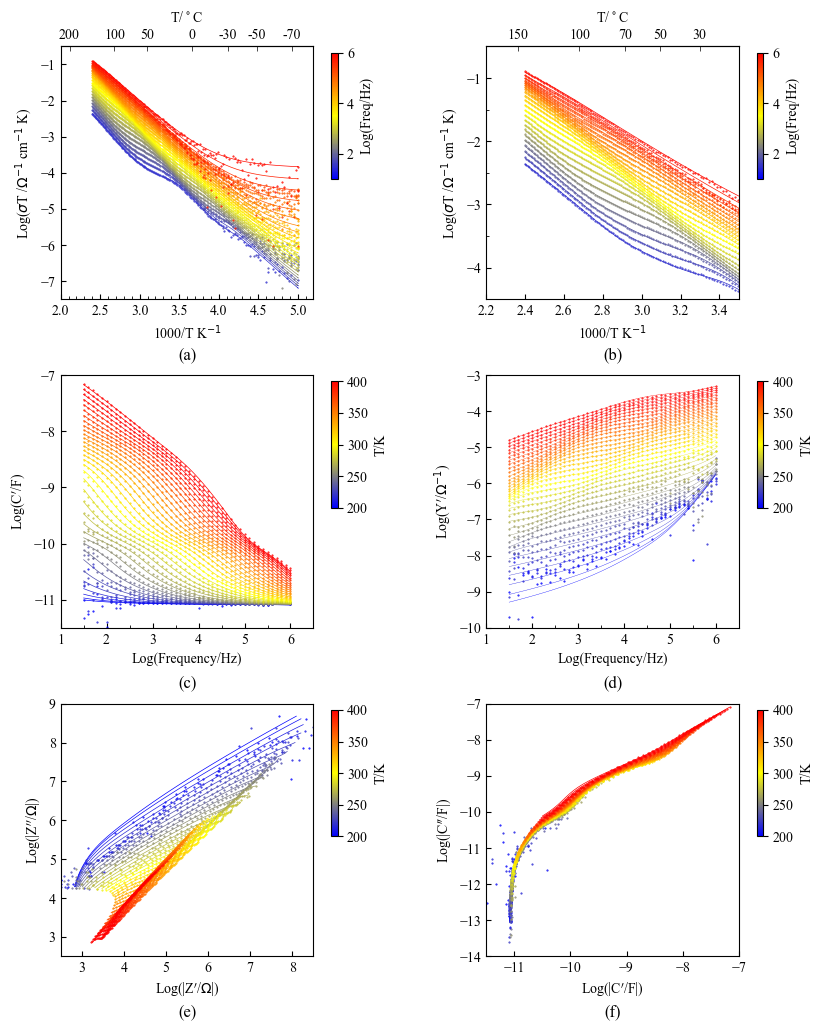

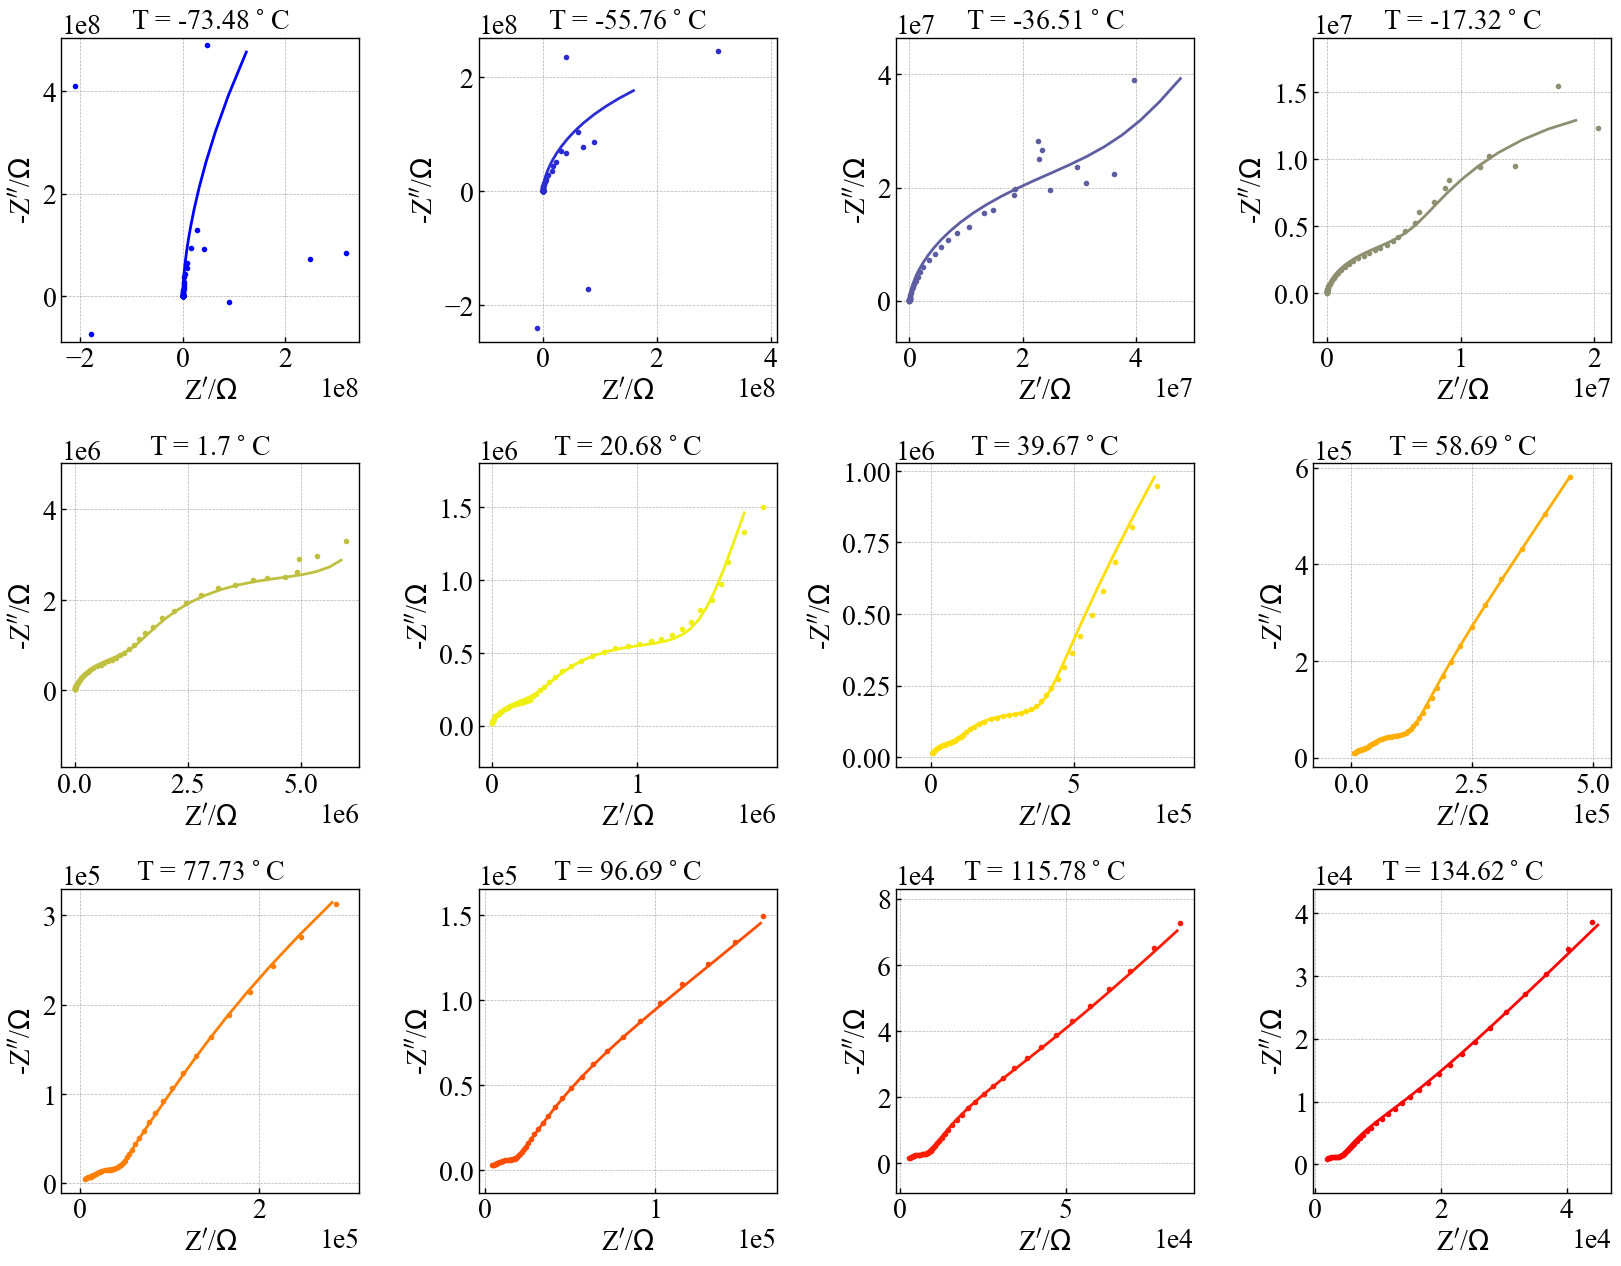

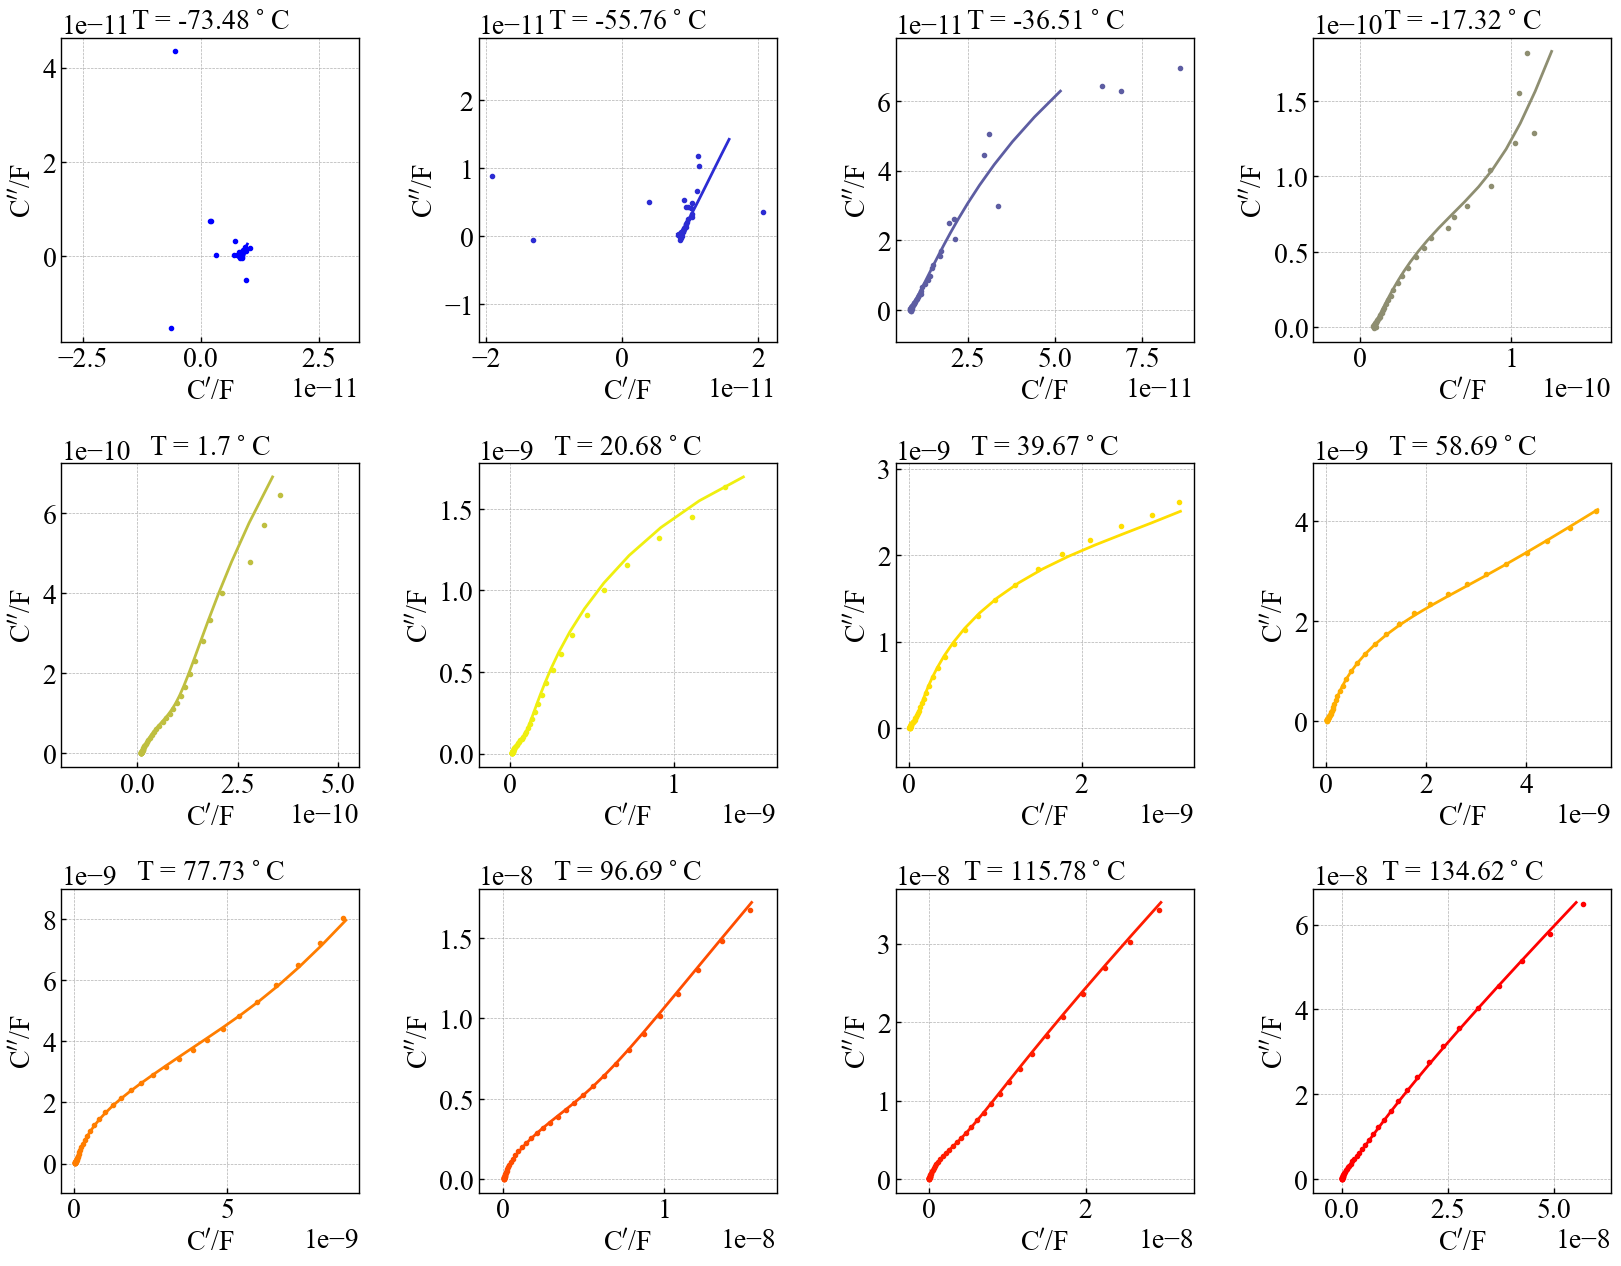


P_1          = 8.33747e-01
P_2          = 1.24324e+00
U_2          = 4.77499e-01
L            = 1.00000e-03
Rstr         = 5.27855e+02
C0           = 3.29066e-12
C1           = 1.27783e-08
C2           = 1.94990e-06
Cdl          = 3.64146e-08
CP           = 4.03204e-06
tau_1_1      = 2.96492e+01
tau_2_1      = 2.42346e+01
QWB_1        = 5.54238e+00
R_T_1        = 1.37492e+01
R_S_1        = 2.27520e+01
ET0          = 5.05098e-01
ET1          = 5.74506e-01
ET2          = 9.17533e-01


In [11]:
# Run leastsquare fitting
selected_indices = [5] # or [3] or any other combination of indices
# 1='unit', 2='dataProportional', 3='calcProportional', 4='dataModulus', 5='calcModulus']

for weighting in selected_indices:
    leastsquares_params[weighting-1,pv_idx],leastsquares_params[weighting-1,pe_idx]=\
    Linh_least_squares(guess, Z, F,Ts,weighting,ls_temperature,list_name_data,txt_folder)
    leastsquares_params[weighting - 1, guess_idx] = guess

pd.DataFrame(leastsquares_params, index=weighting_name).to_csv(params_folder + 'leastsquares_params.csv',
                                                              encoding='ascii', sep=',', header=row_header)
